In [9]:
# neural turing machine with FF as controller
# see also https://github.com/flomlo/ntm_keras
import numpy as np
import math

def tanh_arr(x, d=False):
    if d:
        return 1 - np.tanh(x)
    else:
        return np.tanh(x)

def siginv_arr(y, d=False): # sigmoid inversed
    if d:
        return 1 / y / (1 - y)
    else:
        return np.log( y / (1 - y) )

def sig_arr(x, d=False): # sigmoid
    if d:
        return np.exp(-x) / (1 + np.exp(-x)) ** 2
    else:
        return 1 / (1 + np.exp(-x))

def softmax(x, d=False):
    ex = np.exp(x - np.max(x))
    res = ex / ex.sum()
    if d:
        return res * (1 - res)
    else:
        return res

def simK(u, v): # similarity measure
    return np.dot(u, v) / np.linalg.norm(u) / np.linalg.norm(v)

def weights(wt, wt_1, Mt, kt, betat, gt, st, gammat):
    nmemslots = np.shape(Mt)[0]
    for i in range(nmemslots):
        wt[i] = softmax(betat * simK(Mt[i], kt), False) # content addressing
    wt = gt * wt + (1 - gt) * wt_1 # gated weighing
    wt = np.convolve(wt, st, mode='same') # convolutional shift - todo: circular (does not make a big difference)
    wt = (np.sign(wt) * np.abs(wt) ** gammat) / np.sum(np.sign(wt) * np.abs(wt) ** gammat) # sharpening (careful fractional powers)
    return wt

def concat(atgt, *args): # custom concat
    res = atgt.flatten().tolist()
    for e in args:
        if type(e) is float:
            res += [e]
        elif type(e) is list:
            res += e
        else:
            res += e.flatten().tolist()
    return np.array(res)

def act_fwd(hc, csplit): # activation forward pass
    # subvectors: data + wt-1 + kt + beta + gt + st + gamma + et + at
    # lengths in csplit: ndata + nmemslots + m_depth + 1 + 1 + 3 + 1 + 2 * nmemslots
    # activations: ReLU + ReLU + tanh + ? + ? + soft + sig(inv, clip) + sig + tanh
    yc, wtc, ktc, betatc, gtc, stc, gammatc, etc, atc = np.split(hc, csplit)
    yc = np.maximum(yc, 0, yc) # ReLU
    wtc = np.maximum(wtc, 0, wtc) # ReLU
    ktc = tanh_arr(ktc, False)
    betatc = np.maximum(betatc, 0, betatc) # ReLU ?
    gtc = np.maximum(gtc, 0, gtc) # ReLU ?
    stc = softmax(stc, False)
    gammatc = np.clip(sig_arr(gammatc, False), -1, 1) # ?
    etc = sig_arr(etc, False)
    atc = tanh_arr(atc, False)
    return concat(yc, wtc, ktc, betatc, gtc, stc, gammatc, etc, atc)

def act_bck(hc, csplit): #  activation backpropagation
    # subvectors: data + wt-1 + kt + beta + gt + st + gamma + et + at
    # lengths in csplit: ndata + nmemslots + m_depth + 1 + 1 + 3 + 1 + 2 * nmemslots
    # activations: ReLU + ReLU + tanh + ? + ? + soft + sig(inv, clip) + sig + tanh
    yc, wtc, ktc, betatc, gtc, stc, gammatc, etc, atc = np.split(hc, csplit)
    yc = ((yc > 0) * 1.) # ReLU
    wtc = ((wtc > 0) * 1.) # ReLU
    ktc = tanh_arr(ktc, True)
    betatc = ((betatc > 0) * 1.) # ReLU ?
    gtc = ((gtc > 0) * 1.) # ReLU ?
    stc = softmax(stc, True)
    gammatc = np.clip(sig_arr(gammatc, True), -1, 1) # ?
    etc = sig_arr(etc, True)
    atc = tanh_arr(atc, True)
    return concat(yc, wtc, ktc, betatc, gtc, stc, gammatc, etc, atc)

if __name__=="__main__":
    # parameters
    ndata = 4 # size of external input data
    etha = 0.1 # learning rate
    ntmstps = 20
    
    # fill memory
    m_depth = 3
    Mt = np.array([[1, 0, 1], [0, 1, 1], [1, 1, 0], [1, 0, 1]]) # memory (N slots), m_depth=3
    nmemslots = np.shape(Mt)[0] # 4
    wt = np.array([0.25, 0.25, 0.25, 0.25]) # weights 1-N: one for each memory entry, initial values
    
    # the controller vectors are (data_vector, kt, beta, gt, st, gamma)
    kt = np.zeros((1, m_depth)) # key vector of length M (here: m_depth)
    betat = 0.8 # key strength
    gt = 0.5 # interpolation gate
    st = np.array([0.1, 0.8, 0.1]) # shift weighting
    gammat = 2.0 # sharpening
    # length of controller vector: data + wt-1 + kt + beta + gt + st + gamma + et + at
    nctrlvec = ndata + nmemslots + m_depth + 1 + 1 + 3 + 1 + 2 * nmemslots
    ctrl_inpv = np.zeros((1, nctrlvec)) # input controller
    
    # split vector data + wt-1 + kt + beta + gt + st + gamma
    ctrl_out_split = np.array([ndata, ndata+nmemslots, ndata+nmemslots+m_depth, ndata+nmemslots+m_depth+1, ndata+nmemslots+m_depth+2, ndata+nmemslots+m_depth+5, ndata+nmemslots+m_depth+6, ndata+nmemslots+m_depth+6+nmemslots])
    et = np.zeros((nmemslots)) # erase vector
    at = np.zeros((nmemslots)) # add vector
    
    x = np.zeros((ndata)) # input external data
    y = np.zeros((ndata)) # output external data
    
    # model parameters
    W1 = np.random.randn(nctrlvec, nctrlvec)*0.01 # input to hidden
    W2 = np.random.randn(nctrlvec, nctrlvec)*0.01 # hidden to output
    b1 = np.zeros((1, nctrlvec)) # inp-hidden bias
    b2 = np.zeros((1, nctrlvec)) # hidden-out bias
    
    # time steps
    for thist in range(ntmstps):

        # head moves todo: add multihead
        iheadpos = 0
        while iheadpos < nmemslots:
            wt_1 = wt

            # old memory Mt, read-weights wt from last step: feed read-vector to controller
            # calculate read vector to feed controller
            # read output vector from head location
            rt = np.dot(wt, Mt) # dim M, weighted memories

            # controller runs a single step (with input from outside)
            x = np.array([[0., 1., 0., 0.]]) # receive input vector from outside todo: really outside!
            ctrl_inpv = concat(x, wt, kt, betat, gt, st, gammat, et, at)
            # set indices for erase/add
            if iheadpos > 0:
                et[iheadpos-1] = 0
                at[iheadpos-1] = 0
            et[iheadpos] = 1
            at[iheadpos] = 1
            # controller forward pass, single step
            h1 = np.dot(ctrl_inpv, W1) + b1
            #h1 = np.maximum(h1, 0, h1) # ReLU todo: different by parameter
            h1 = act_fwd(h1[0], ctrl_out_split) # forward pass (different activation by subvector)
            o2 = np.dot(h1, W2) + b2
            # backward pass
            y[1] = 1. # arbitrary external output data (truth), todo: check, what is the entire truth?
            ctrl_outv = concat(y, wt, kt, betat, gt, st, gammat, et, at)
            #dW1 = - etha * (o2 - ctrl_outv) * np.maximum(h1, 0, h1)
            dW1 = - etha * (o2 - ctrl_outv) * h1
            dW2 = dW1 * act_bck(h1, ctrl_out_split) * ctrl_inpv
            W1 += dW1
            W2 += dW2

            # controller unactivated output divided into actual data output, reading, writing instructions
            # split: output_dim, read_heads, write_heads
            # split and apply activations:
            # k and add_vector are activated via tanh, erase_vector via sigmoid (this is critical!),
            # shift via softmax, gamma is sigmoided, inversed and clipped (probably not ideal)
            # g is sigmoided, beta is linear (probably not ideal!)
            y, wt, kt, betat, gt, st, gammat, et, at = np.split(o2[0], ctrl_out_split)

            # write memory for each head: calculate weights, erase, add
            wt = weights(wt, wt_1, Mt, kt, betat, gt, st, gammat)
            Mt = Mt - Mt * np.dot(wt, et.T) # erase
            Mt = Mt + np.dot(wt, at.T) # add

            # calculate read weights, save in the state and use for next round
            # todo
            iheadpos += 1
            
            print(Mt)

[[1.0056956  0.00283298 1.0056956 ]
 [0.00283298 1.0056956  1.0056956 ]
 [1.0056956  1.0056956  0.00283298]
 [1.0056956  0.00283298 1.0056956 ]]
[[ 1.00738054 -0.00445907  1.00738054]
 [-0.00445907  1.00738054  1.00738054]
 [ 1.00738054  1.00738054 -0.00445907]
 [ 1.00738054 -0.00445907  1.00738054]]
[[1.04046079 0.02812179 1.04046079]
 [0.02812179 1.04046079 1.04046079]
 [1.04046079 1.04046079 0.02812179]
 [1.04046079 0.02812179 1.04046079]]
[[1.11678237 0.0192001  1.11678237]
 [0.0192001  1.11678237 1.11678237]
 [1.11678237 1.11678237 0.0192001 ]
 [1.11678237 0.0192001  1.11678237]]
[[1.14458933 0.03843599 1.14458933]
 [0.03843599 1.14458933 1.14458933]
 [1.14458933 1.14458933 0.03843599]
 [1.14458933 0.03843599 1.14458933]]
[[ 0.33186761 -0.75729888  0.33186761]
 [-0.75729888  0.33186761  0.33186761]
 [ 0.33186761  0.33186761 -0.75729888]
 [ 0.33186761 -0.75729888  0.33186761]]
[[ 0.36044297 -0.71576451  0.36044297]
 [-0.71576451  0.36044297  0.36044297]
 [ 0.36044297  0.36044297 -0

In [13]:
import random

def rdbinseq(l): # random sequence of 8-bit binary vectors (int 0-255)
    if l <= 0:
        return []
    res = []
    for i in range(l):
        res.append(random.randint(0, 255))
    return res

def rdbinseqb(n, l): # random sequence of n-bit binary vectors
    if l <= 0:
        return []
    res = []
    for i in range(l):
        res.append([random.randint(0, 1) for j in range(n)])
    return res

if __name__=="__main__":
    print(int('11111111', 2))
    print(rdbinseq(10))
    print(rdbinseqb(8, 10))

255
[94, 49, 73, 128, 174, 45, 45, 198, 156, 2]
[[1, 1, 1, 0, 0, 1, 1, 0], [1, 1, 1, 0, 1, 1, 0, 0], [0, 1, 0, 0, 0, 1, 1, 1], [1, 1, 1, 0, 1, 1, 1, 1], [0, 1, 0, 1, 1, 1, 1, 1], [0, 0, 1, 0, 0, 1, 0, 0], [1, 1, 1, 0, 1, 1, 1, 0], [1, 0, 1, 1, 0, 0, 1, 0], [1, 0, 1, 1, 0, 1, 0, 1], [0, 0, 1, 1, 1, 1, 1, 0]]


In [5]:
# neural turing machine with FF as controller
# copy task
import numpy as np
import math
import random

def rdbinseqb(n, l): # random sequence of n-bit binary vectors
    if l <= 0:
        return []
    res = []
    for i in range(l):
        res.append([random.randint(0, 1) for j in range(n)])
    return res

def tanh_arr(x, d=False):
    if d:
        return 1 - np.tanh(x)
    else:
        return np.tanh(x)

def siginv_arr(y, d=False): # sigmoid inversed
    if d:
        return 1 / y / (1 - y)
    else:
        return np.log( y / (1 - y) )

def sig_arr(x, d=False): # sigmoid
    if d:
        return np.exp(-x) / (1 + np.exp(-x)) ** 2
    else:
        return 1 / (1 + np.exp(-x))

def softmax(x, d=False):
    ex = np.exp(x - np.max(x))
    res = ex / ex.sum()
    if d:
        return res * (1 - res)
    else:
        return res

def simK(u, v): # similarity measure
    return np.dot(u, v) / np.linalg.norm(u) / np.linalg.norm(v)

def weights(wt, wt_1, Mt, kt, betat, gt, st, gammat):
    nmemslots = np.shape(Mt)[0]
    for i in range(nmemslots):
        wt[i] = softmax(betat * simK(Mt[i], kt), False) # content addressing
    wt = gt * wt + (1 - gt) * wt_1 # gated weighing
    wt = np.convolve(wt, st, mode='same') # convolutional shift - todo: circular (does not make a big difference)
    wt = (np.sign(wt) * np.abs(wt) ** gammat) / np.sum(np.sign(wt) * np.abs(wt) ** gammat) # sharpening (careful fractional powers)
    return wt

def concat(atgt, *args): # custom concat
    res = atgt.flatten().tolist()
    for e in args:
        if type(e) is float:
            res += [e]
        elif type(e) is list:
            res += e
        else:
            res += e.flatten().tolist()
    return np.array(res)

def act_fwd(hc, csplit): # activation forward pass
    # subvectors: data + wt-1 + kt + beta + gt + st + gamma + et + at
    # lengths in csplit: ndata + nmemslots + m_depth + 1 + 1 + 3 + 1 + 2 * nmemslots
    # activations: ReLU + ReLU + tanh + ? + ? + soft + sig(inv, clip) + sig + tanh
    yc, wtc, ktc, betatc, gtc, stc, gammatc, etc, atc = np.split(hc, csplit)
    yc = np.maximum(yc, 0, yc) # ReLU
    wtc = np.maximum(wtc, 0, wtc) # ReLU
    ktc = tanh_arr(ktc, False)
    betatc = np.maximum(betatc, 0, betatc) # ReLU ?
    gtc = np.maximum(gtc, 0, gtc) # ReLU ?
    stc = softmax(stc, False)
    gammatc = np.clip(sig_arr(gammatc, False), -1, 1) # ?
    etc = sig_arr(etc, False)
    atc = tanh_arr(atc, False)
    return concat(yc, wtc, ktc, betatc, gtc, stc, gammatc, etc, atc)

def act_bck(hc, csplit): #  activation backpropagation
    # subvectors: data + wt-1 + kt + beta + gt + st + gamma + et + at
    # lengths in csplit: ndata + nmemslots + m_depth + 1 + 1 + 3 + 1 + 2 * nmemslots
    # activations: ReLU + ReLU + tanh + ? + ? + soft + sig(inv, clip) + sig + tanh
    yc, wtc, ktc, betatc, gtc, stc, gammatc, etc, atc = np.split(hc, csplit)
    yc = ((yc > 0) * 1.) # ReLU
    wtc = ((wtc > 0) * 1.) # ReLU
    ktc = tanh_arr(ktc, True)
    betatc = ((betatc > 0) * 1.) # ReLU ?
    gtc = ((gtc > 0) * 1.) # ReLU ?
    stc = softmax(stc, True)
    gammatc = np.clip(sig_arr(gammatc, True), -1, 1) # ?
    etc = sig_arr(etc, True)
    atc = tanh_arr(atc, True)
    return concat(yc, wtc, ktc, betatc, gtc, stc, gammatc, etc, atc)

if __name__=="__main__":
    # parameters
    ndata = 4 # size of external input data
    etha = 0.1 # learning rate
    ntmstps = 10
    
    # fill memory
    m_depth = 3
    #Mt = np.array([[1, 0, 1], [0, 1, 1], [1, 1, 0], [1, 0, 1]]) # memory (N slots), m_depth=3
    Mt = np.array(rdbinseqb(3, 4))
    print(Mt)
    nmemslots = np.shape(Mt)[0] # 4
    wt = np.array([0.25, 0.25, 0.25, 0.25]) # weights 1-N: one for each memory entry, initial values
    
    # the controller vectors are (data_vector, kt, beta, gt, st, gamma)
    kt = np.zeros((1, m_depth)) # key vector of length M (here: m_depth)
    betat = 0.8 # key strength
    gt = 0.5 # interpolation gate
    st = np.array([0.1, 0.8, 0.1]) # shift weighting
    gammat = 2.0 # sharpening
    # length of controller vector: data + wt-1 + kt + beta + gt + st + gamma + et + at
    nctrlvec = ndata + nmemslots + m_depth + 1 + 1 + 3 + 1 + 2 * nmemslots
    ctrl_inpv = np.zeros((1, nctrlvec)) # input controller
    
    # split vector data + wt-1 + kt + beta + gt + st + gamma
    ctrl_out_split = np.array([ndata, ndata+nmemslots, ndata+nmemslots+m_depth, ndata+nmemslots+m_depth+1, ndata+nmemslots+m_depth+2, ndata+nmemslots+m_depth+5, ndata+nmemslots+m_depth+6, ndata+nmemslots+m_depth+6+nmemslots])
    et = np.zeros((nmemslots)) # erase vector
    at = np.zeros((nmemslots)) # add vector
    
    x = np.zeros((ndata)) # input external data
    y = np.zeros((ndata)) # output external data
    
    # model parameters
    W1 = np.random.randn(nctrlvec, nctrlvec)*0.01 # input to hidden
    W2 = np.random.randn(nctrlvec, nctrlvec)*0.01 # hidden to output
    b1 = np.zeros((1, nctrlvec)) # inp-hidden bias
    b2 = np.zeros((1, nctrlvec)) # hidden-out bias
    
    # time steps
    for thist in range(ntmstps):

        # head moves todo: add multihead
        iheadpos = 0
        while iheadpos < nmemslots:
            wt_1 = wt

            # old memory Mt, read-weights wt from last step: feed read-vector to controller
            # calculate read vector to feed controller
            # read output vector from head location
            rt = np.dot(wt, Mt) # dim M, weighted memories

            # controller runs a single step (with input from outside)
            x = np.array([[0., 1., 0., 0.]]) # receive input vector from outside todo: really outside!
            ctrl_inpv = concat(x, wt, kt, betat, gt, st, gammat, et, at)
            # set indices for erase/add
            if iheadpos > 0:
                et[iheadpos-1] = 0
                at[iheadpos-1] = 0
            et[iheadpos] = 1
            at[iheadpos] = 1
            # controller forward pass, single step
            h1 = np.dot(ctrl_inpv, W1) + b1
            #h1 = np.maximum(h1, 0, h1) # ReLU todo: different by parameter
            h1 = act_fwd(h1[0], ctrl_out_split) # forward pass (different activation by subvector)
            o2 = np.dot(h1, W2) + b2
            # backward pass
            y[1] = 1. # arbitrary external output data (truth), todo: check, what is the entire truth?
            ctrl_outv = concat(y, wt, kt, betat, gt, st, gammat, et, at)
            #dW1 = - etha * (o2 - ctrl_outv) * np.maximum(h1, 0, h1)
            dW1 = - etha * (o2 - ctrl_outv) * h1
            dW2 = dW1 * act_bck(h1, ctrl_out_split) * ctrl_inpv
            W1 += dW1
            W2 += dW2

            # controller unactivated output divided into actual data output, reading, writing instructions
            # split: output_dim, read_heads, write_heads
            # split and apply activations:
            # k and add_vector are activated via tanh, erase_vector via sigmoid (this is critical!),
            # shift via softmax, gamma is sigmoided, inversed and clipped (probably not ideal)
            # g is sigmoided, beta is linear (probably not ideal!)
            y, wt, kt, betat, gt, st, gammat, et, at = np.split(o2[0], ctrl_out_split)

            # write memory for each head: calculate weights, erase, add
            wt = weights(wt, wt_1, Mt, kt, betat, gt, st, gammat)
            Mt = Mt - Mt * np.dot(wt, et.T) # erase
            Mt = Mt + np.dot(wt, at.T) # add

            # calculate read weights, save in the state and use for next round
            # todo
            iheadpos += 1
            
    print(Mt)

[[0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]]
[[-0.27381219  1.28205607 -0.27381219]
 [-0.27381219 -0.27381219  1.28205607]
 [ 1.28205607 -0.27381219 -0.27381219]
 [-0.27381219  1.28205607 -0.27381219]]


In [14]:
# key-value-query attention test - full matrix version
import numpy as np
import math

def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / ex.sum()

if __name__=="__main__":
    input_sent = 'thinking machines'
    # embeddings
    xn = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

    # weights
    Wk = np.array([[-1, 0, 1], [0, 1, 1], [1, -1, 0], [1, 0, -1]])
    Wv = np.array([[0, 1, -1], [-1, 0, 1], [1, 0, 1], [0, 1, 1]])
    Wq = np.array([[-1, 1, 0], [1, 1, 0], [-1, 0, 1], [-1, 1, 0]])

    # query, key, value
    qn = np.dot(Wq.T, xn.T)
    kn = np.dot(Wk.T, xn.T)
    vn = np.dot(Wv.T, xn.T)

    print('qkvn ', qn, kn, vn)

    # scores
    sn = np.dot(qn.T, kn)
    print('scores ', sn)

    # key dimension
    dn = np.shape(kn)[0]
    print(dn)
    sn = np.true_divide(sn, np.sqrt(dn))
    print('scores corrected for dim ', sn)
    
    # softmax
    sn = softmax(sn)
    print('softmax ', sn)
    
    # weighted value vectors
    zn = np.dot(sn, vn.T)
    print('weighted values ', zn)
    
    # sum up weighted value vectors
    zsum = np.sum(zn, axis=0)
    print('weighted sum ', zsum)

qkvn  [[-1  1]
 [ 1  1]
 [ 0  0]] [[-1  0]
 [ 0  1]
 [ 1  1]] [[ 0 -1]
 [ 1  0]
 [-1  1]]
scores  [[ 1  1]
 [-1  1]]
3
scores corrected for dim  [[ 0.57735027  0.57735027]
 [-0.57735027  0.57735027]]
softmax  [[0.3016453  0.3016453 ]
 [0.09506409 0.3016453 ]]
weighted values  [[-0.3016453   0.3016453   0.        ]
 [-0.3016453   0.09506409  0.20658121]]
weighted sum  [-0.60329061  0.39670939  0.20658121]


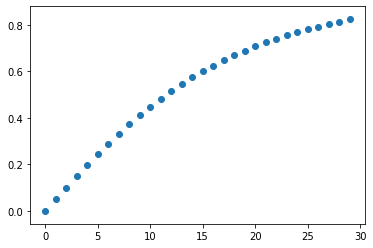

[[-0.07392436  0.11811963  0.04419527]
 [-0.03939406  0.11811963  0.20174407]
 [-0.06150925  0.17587763 -0.02597784]
 [-0.07392436  0.11811963  0.04419527]]


In [2]:
# similarity test
import numpy as np
import matplotlib.pyplot as plt

def softmax(x, d=False):
    ex = np.exp(x - np.max(x))
    res = ex / ex.sum()
    if d:
        return res * (1 - res)
    else:
        return res

def simK(u, v): # similarity measure
    return np.dot(u, v) / np.linalg.norm(u) / np.linalg.norm(v)

def attention(q, k, v): # scaled dot-product attention
    dk = np.shape(k)[1] # dimension of keys
    #return np.dot(softmax(np.true_divide(np.dot(q, k.T), np.sqrt(dk))), v)
    return np.dot(softmax(np.true_divide(np.dot(q, k.T), np.sqrt(dk))), v)

if __name__=="__main__":
    v0 = np.array([[1,0]])
    x = range(0,30)
    y = [simK(v0, np.array([[v/20,1]]).T) for v in x]
    plt.scatter(x, y)
    plt.show()
    Q = np.array([[-1, 1, 0], [1, 1, 0], [-1, 0, 1], [-1, 1, 0]]) # query
    K = np.array([[-1, 0, 1], [0, 1, 1], [1, -1, 0], [1, 0, -1]]) # key
    V = np.array([[0, 1, -1], [-1, 0, 1], [1, 0, 1], [0, 1, 1]]) # value
    print(attention(Q, K, V))

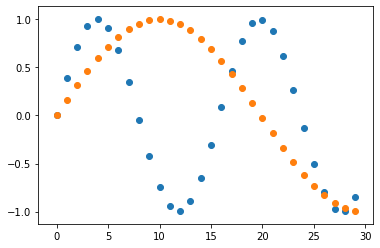

In [19]:
# positional encoding test
import numpy as np
import matplotlib.pyplot as plt

def posenc(pos, dim_i, dim_model):
    return np.sin(pos / 100 ** (2 * dim_i / dim_model)) # was 10000, just for demo purposes

if __name__=="__main__":
    x = range(0,30)
    y0 = [posenc(v, 1, 10) for v in x]
    y1 = [posenc(v, 2, 10) for v in x]
    plt.scatter(x, y0)
    plt.scatter(x, y1)
    plt.show()

In [6]:
# test multihead
import numpy as np

def softmax(x, d=False):
    ex = np.exp(x - np.max(x))
    res = ex / ex.sum()
    if d:
        return res * (1 - res)
    else:
        return res

def attention(q, k, v): # scaled dot-product attention
    dk = np.shape(k)[1] # dimension of keys
    #return np.dot(softmax(np.true_divide(np.dot(q, k.T), np.sqrt(dk))), v)
    return np.dot(softmax(np.true_divide(np.dot(q, k.T), np.sqrt(dk))), v)

if __name__=="__main__":
    Q = np.random.rand(4,3) # query
    K = np.random.rand(4,3) # key
    V = np.random.rand(4,3) # value
    Z0 = attention(Q, K, V)
    Q = np.random.rand(4,3) # query
    K = np.random.rand(4,3) # key
    V = np.random.rand(4,3) # value
    Z1 = attention(Q, K, V)
    Q = np.random.rand(4,3) # query
    K = np.random.rand(4,3) # key
    V = np.random.rand(4,3) # value
    Z2 = attention(Q, K, V)
    Z = np.concatenate((Z0, Z1, Z2), axis = 1)
    Wo = np.random.rand(9,3) # multihead weights
    print(np.dot(Z, Wo)) # multihead output

[[0.4031242  0.36105405 0.40070663]
 [0.43829316 0.40113467 0.43872444]
 [0.40429546 0.36660719 0.41710913]
 [0.47078224 0.46717061 0.54047291]]


In [16]:
# layer normalization and residual connection test with simple FF NW
import numpy as np

if __name__=='__main__':
    # parameters
    inp_size = 10 # input size
    etha = 0.1 # learning rate
    niter = 10

    # input
    x = np.zeros((1, inp_size)) # input
    x = [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]

    # model parameters
    W1 = np.random.randn(inp_size, inp_size)*0.01 # input to hidden
    W2 = np.random.randn(inp_size, inp_size)*0.01 # hidden to output
    b1 = np.zeros((1, inp_size)) # inp-hidden bias
    b2 = np.zeros((1, inp_size)) # hidden-out bias
    g1 = np.ones((1, inp_size)) # gain parameter inp-hidden
    g2 = np.ones((1, inp_size)) # gain parameter hidden-out
    
    for ictr in range(niter):

        # forward pass
        h1 = np.dot(x, W1)
        mn1 = np.mean(h1)
        std1 = np.std(h1)
        h1 = g1 / std1 * (h1 - mn1) + b1 # todo: learn g and bias
        h1 = np.maximum(h1, 0, h1) # ReLU
        o2 = np.dot(h1, W2)
        mn2 = np.mean(o2)
        std2 = np.std(o2)
        o2 = g2 / std2 * (o2 - mn2) + b2 # todo: learn g and bias
        o2 += x # residual connection
        #print(o2)

        # backward pass
        y = [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]
        h1 = np.dot(x, W1) + b1
        dW1 = - etha * (o2 - y) * np.maximum(h1, 0, h1)
        dW2 = dW1 * ((h1 > 0) * 1.) * x
        
        # todo: fix adaptive gain and bias backprop
        #db1 = - etha * (o2 - y)
        #db2 = - etha * (o2 - y) * g2 / std2 * np.maximum(h1, 0, h1)
        #dg1 = - etha * (o2 - y) * (h1 - mn2) / std2
        #dg2 = - etha * (o2 - y) * g2 / std2 * np.maximum(h1, 0, h1) / std1 * h1
        
        W1 += dW1
        W2 += dW2
        
        #b1 += db1
        #b2 += db2
        #g1 += dg1
        #g2 += dg2
        
    print(dW1)
    print(dW2)
    # forward pass
    h1 = np.dot(x, W1) + b1
    h1 = np.maximum(h1, 0, h1) # ReLU
    o2 = np.dot(h1, W2) + b2
    print(o2)

[[-6.59550202e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.97902749e-05 -1.83366045e-04  0.00000000e+00
   1.30374758e-03 -1.22674908e-04]]
[[-0.  0.  0.  0.  0.  0. -0.  0.  0. -0.]]
[[ 5.32641215e-04 -7.28310529e-05 -6.25439830e-05 -9.23457828e-05
  -6.06639073e-04 -6.59378572e-05  3.89195061e-04 -1.01978208e-04
  -1.39265739e-04  3.39733429e-05]]
